# Inference Data Cookbook
`InferenceData` is the central data format for ArviZ. `InferenceData` itself is just a container that maintains references to one or more `xarray.Dataset`. See the `InferenceData` structure specification [here](../schema/schema.html). Below are various ways to generate an `InferenceData` object. See [here](XarrayforArviZ.ipynb) for more on xarray.

## Table of contents

In [1]:
import arviz as az
import numpy as np

## From 1d numpy array

In [2]:
size = 100
dataset = az.convert_to_inference_data(np.random.randn(size))
dataset

Inference data with groups:
	> posterior

In [3]:
dataset.posterior

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 100)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    x        (chain, draw) float64 1.589 -0.09337 -1.031 ... 1.247 -1.529
Attributes:
    created_at:     2020-06-02T02:02:20.873999
    arviz_version:  0.8.3

## From nd numpy array


In [4]:
shape = (1, 2, 3, 4, 5)
dataset = az.convert_to_inference_data(np.random.randn(*shape))
dataset

Inference data with groups:
	> posterior

In [5]:
dataset.posterior

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 2, x_dim_0: 3, x_dim_1: 4, x_dim_2: 5)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1
  * x_dim_0  (x_dim_0) int64 0 1 2
  * x_dim_1  (x_dim_1) int64 0 1 2 3
  * x_dim_2  (x_dim_2) int64 0 1 2 3 4
Data variables:
    x        (chain, draw, x_dim_0, x_dim_1, x_dim_2) float64 0.1614 ... 0.00804
Attributes:
    created_at:     2020-06-02T02:02:24.365287
    arviz_version:  0.8.3

## From a dictionary

In [6]:
datadict = {
    "a": np.random.randn(100),
    "b": np.random.randn(1, 100, 10),
    "c": np.random.randn(1, 100, 3, 4),
}
dataset = az.convert_to_inference_data(datadict)
dataset

Inference data with groups:
	> posterior

In [7]:
dataset.posterior

<xarray.Dataset>
Dimensions:  (b_dim_0: 10, c_dim_0: 3, c_dim_1: 4, chain: 1, draw: 100)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * b_dim_0  (b_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * c_dim_0  (c_dim_0) int64 0 1 2
  * c_dim_1  (c_dim_1) int64 0 1 2 3
Data variables:
    a        (chain, draw) float64 -0.5718 0.1517 -0.5055 ... 1.629 -2.573
    b        (chain, draw, b_dim_0) float64 -0.3169 -0.6537 ... -0.5796 -0.1467
    c        (chain, draw, c_dim_0, c_dim_1) float64 0.1671 0.1605 ... 0.6655
Attributes:
    created_at:     2020-05-22T18:37:44.138117
    arviz_version:  0.7.0

## From dictionary with coords and dims

In [8]:
datadict = {
    "a": np.random.randn(100),
    "b": np.random.randn(1, 100, 10),
    "c": np.random.randn(1, 100, 3, 4),
}
coords = {"c1": np.arange(3), "c2": np.arange(4), "b1": np.arange(10)}
dims = {"b": ["b1"], "c": ["c1", "c2"]}

dataset = az.convert_to_inference_data(datadict, coords=coords, dims=dims)
dataset

Inference data with groups:
	> posterior

In [9]:
dataset.posterior

<xarray.Dataset>
Dimensions:  (b1: 10, c1: 3, c2: 4, chain: 1, draw: 100)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * b1       (b1) int64 0 1 2 3 4 5 6 7 8 9
  * c1       (c1) int64 0 1 2
  * c2       (c2) int64 0 1 2 3
Data variables:
    a        (chain, draw) float64 0.01982 -0.9719 -1.809 ... 2.027 -1.217
    b        (chain, draw, b1) float64 0.1776 0.07881 -1.17 ... -1.019 0.2414
    c        (chain, draw, c1, c2) float64 1.02 -0.4499 ... -2.762 -0.9751
Attributes:
    created_at:     2020-05-22T18:37:44.177562
    arviz_version:  0.7.0

## From PyMC3

In [10]:
import pymc3 as pm

draws = 500
chains = 2

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

In [11]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sd=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_tilde", mu=0, sd=1, shape=eight_school_data["J"])
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    pm.Normal(
        "obs", mu=theta, sd=eight_school_data["sigma"], observed=eight_school_data["y"]
    )

    trace = pm.sample(draws, chains=chains)
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

    pm_data = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords={"school": np.arange(eight_school_data["J"])},
        dims={"theta": ["school"], "theta_tilde": ["school"]},
    )
pm_data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_tilde, tau, mu]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

## From PyStan

In [12]:
import pystan

schools_code = """
data {
    int<lower=0> J;
    real y[J];
    real<lower=0> sigma[J];
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[J];
}

transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] = mu + tau * theta_tilde[j];
}

model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(theta, sigma);
}

generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

stan_model = pystan.StanModel(model_code=schools_code)
fit = stan_model.sampling(data=eight_school_data, control={"adapt_delta": 0.9})

stan_data = az.from_pystan(
    posterior=fit,
    posterior_predictive="y_hat",
    observed_data=["y"],
    log_likelihood={"y": "log_lik"},
    coords={"school": np.arange(eight_school_data["J"])},
    dims={
        "theta": ["school"],
        "y": ["school"],
        "log_lik": ["school"],
        "y_hat": ["school"],
        "theta_tilde": ["school"],
    },
)

stan_data

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9d743830ec4a29fb58eb4660d4b9417f NOW.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

## From Pyro

In [13]:
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import MCMC, NUTS, Predictive

pyro.enable_validation(True)
pyro.set_rng_seed(0)

draws = 500
chains = 2
eight_school_data = {
    "J": 8,
    "y": torch.tensor([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": torch.tensor([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}


def model(J, sigma, y=None):
    mu = pyro.sample("mu", dist.Normal(0, 5))
    tau = pyro.sample("tau", dist.HalfCauchy(5))
    with pyro.plate("J", J):
        theta_tilde = pyro.sample("theta_tilde", dist.Normal(0, 1))
        theta = mu + tau * theta_tilde
        return pyro.sample("obs", dist.Normal(theta, sigma), obs=y)


nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(
    nuts_kernel,
    num_samples=draws,
    warmup_steps=draws,
    num_chains=chains,
    disable_progbar=True,
)
mcmc.run(**eight_school_data)
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples).get_samples(
    eight_school_data["J"], eight_school_data["sigma"]
)
prior = Predictive(model, num_samples=500).get_samples(
    eight_school_data["J"], eight_school_data["sigma"]
)

pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"school": np.arange(eight_school_data["J"])},
    dims={"theta": ["school"]},
)
pyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

## From emcee

In [14]:
import emcee

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}


def log_prior_8school(theta, J):
    mu = theta[0]
    tau = theta[1]
    eta = theta[2:]
    # Half-cauchy prior
    if tau < 0:
        return -np.inf
    hwhm = 25
    prior_tau = -np.log(tau ** 2 + hwhm ** 2)
    prior_mu = -((mu / 10) ** 2)  # normal prior, loc=0, scale=10
    prior_eta = -np.sum(eta ** 2)  # normal prior, loc=0, scale=1
    return prior_mu + prior_tau + prior_eta


def log_likelihood_8school(theta, y, sigma):
    mu = theta[0]
    tau = theta[1]
    eta = theta[2:]
    return -np.sum(((mu + tau * eta - y) / sigma) ** 2)


def lnprob_8school(theta, J, y, sigma):
    prior = log_prior_8school(theta, J)
    if prior <= -np.inf:
        return -np.inf
    like = log_likelihood_8school(theta, y, sigma)
    return like + prior


nwalkers = 40
ndim = eight_school_data["J"] + 2
draws = 1500
pos = np.random.normal(size=(nwalkers, ndim))
pos[:, 1] = np.absolute(pos[:, 1])
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    lnprob_8school,
    args=(eight_school_data["J"], eight_school_data["y"], eight_school_data["sigma"]),
)
sampler.run_mcmc(pos, draws)

# define variable names, it cannot be inferred from emcee
var_names = ["mu", "tau"] + ["eta{}".format(i) for i in range(eight_school_data["J"])]
emcee_data = az.from_emcee(sampler, var_names=var_names)
emcee_data

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

## From CmdStanPy

In [15]:
from cmdstanpy import CmdStanModel

schools_code = """
data {
    int<lower=0> J;
    real y[J];
    real<lower=0> sigma[J];
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[J];
}

transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] = mu + tau * theta_tilde[j];
}

model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(theta, sigma);
}

generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

with open("./eight_school.stan", "w") as f:
    print(schools_code, file=f)

stan_file = "./eight_school.stan"
stan_model = CmdStanModel(stan_file=stan_file)
stan_model.compile()

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

stan_fit = stan_model.sample(data=eight_school_data)

cmdstanpy_data = az.from_cmdstanpy(
    posterior=stan_fit,
    posterior_predictive="y_hat",
    observed_data={"y": eight_school_data["y"]},
    log_likelihood="log_lik",
    coords={"school": np.arange(eight_school_data["J"])},
    dims={
        "theta": ["school"],
        "y": ["school"],
        "log_lik": ["school"],
        "y_hat": ["school"],
        "theta_tilde": ["school"],
    },
)
cmdstanpy_data

INFO:cmdstanpy:compiling stan program, exe file: /Users/alex_andorra/tptm_alex/arviz/doc/notebooks/eight_school
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/alex_andorra/tptm_alex/arviz/doc/notebooks/eight_school
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/alex_andorra/tptm_alex/arviz/doc/notebooks/eight_school
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

## From CmdStan

See [from_cmdstan](https://arviz-devs.github.io/arviz/generated/arviz.from_cmdstan.html#arviz.from_cmdstan) for details.

### CmdStan helpers

In [16]:
# save for CmdStan example (needs CmdStanPy run)
stan_fit.save_csvfiles(dir="sample_data")

In [17]:
schools_code = """
data {
    int<lower=0> J;
    real y[J];
    real<lower=0> sigma[J];
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[J];
}

transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] = mu + tau * theta_tilde[j];
}

model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(theta, sigma);
}

generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

with open("./eight_school.stan", "w") as f:
    print(schools_code, file=f)

In [18]:
eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

In [19]:
import pystan

pystan.stan_rdump(eight_school_data, "./eight_school.data.R")

In [20]:
# Bash shell
#
# $ cd cmdstan
# $ make build
# $ make path/to/eight_school
# $ cd path/to
# $ for i in {1..4}
#   do
#     ./eight_school sample random seed=12345 \
#       id=$i data file=eight_school.data.R \
#       output file=sample_data/eight_school_samples-$i.csv &
#   done
# $

In [21]:
# Let's use .stan and .csv files created/saved by the CmdStanPy procedure

# glob string
posterior_glob = "sample_data/eight_school-*-[0-9].csv"
# list of paths
# posterior_list =  [
#     "sample_data/eight_school-*-1.csv",
#     "sample_data/eight_school-*-2.csv",
#     "sample_data/eight_school-*-3.csv",
#     "sample_data/eight_school-*-4.csv",
# ]

obs_data_path = "./eight_school.data.R"

cmdstan_data = az.from_cmdstan(
    posterior=posterior_glob,
    posterior_predictive="y_hat",
    observed_data=obs_data_path,
    observed_data_var="y",
    log_likelihood="log_lik",
    coords={"school": np.arange(eight_school_data["J"])},
    dims={
        "theta": ["school"],
        "y": ["school"],
        "log_lik": ["school"],
        "y_hat": ["school"],
        "theta_tilde": ["school"],
    },
)
cmdstan_data

arviz.data.io_cmdstan - INFO - glob found 4 files for 'posterior':
1: sample_data/eight_school-202005222038-1.csv
2: sample_data/eight_school-202005222038-2.csv
3: sample_data/eight_school-202005222038-3.csv
4: sample_data/eight_school-202005222038-4.csv
INFO:arviz.data.io_cmdstan:glob found 4 files for 'posterior':
1: sample_data/eight_school-202005222038-1.csv
2: sample_data/eight_school-202005222038-2.csv
3: sample_data/eight_school-202005222038-3.csv
4: sample_data/eight_school-202005222038-4.csv


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

## From NumPyro

In [22]:
import numpyro
import numpyro.distributions as dist

from jax.random import PRNGKey
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive

numpyro.set_host_device_count(4)

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}


def model(J, sigma, y=None):
    mu = numpyro.sample("mu", dist.Normal(0, 5))
    tau = numpyro.sample("tau", dist.HalfCauchy(5))
    # use non-centered reparameterization
    theta = numpyro.sample(
        "theta",
        dist.TransformedDistribution(
            dist.Normal(np.zeros(J), 1), AffineTransform(mu, tau)
        ),
    )
    numpyro.sample("y", dist.Normal(theta, sigma), obs=y)


kernel = NUTS(model)
mcmc = MCMC(
    kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method="parallel"
)
mcmc.run(PRNGKey(0), **eight_school_data, extra_fields=["num_steps", "energy"])
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples).get_samples(
    PRNGKey(1), eight_school_data["J"], eight_school_data["sigma"]
)
prior = Predictive(model, num_samples=500).get_samples(
    PRNGKey(2), eight_school_data["J"], eight_school_data["sigma"]
)

numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"school": np.arange(eight_school_data["J"])},
    dims={"theta": ["school"]},
)
numpyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

## From PyJAGS

### Import Packages

In [1]:
import arviz as az
import numpy as np
import pyjags
import xarray as xr
xr.set_options(display_style="html");


Bad key "text.kerning_factor" on line 4 in
/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Construct Data Dictionary for PyJAGS

In [2]:
eight_school_data = {
    "J": 8, 
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

### JAGS Model Code

#### Prior Model

In [3]:
eight_school_prior_model_code = ''' 
model {
    mu ~ dnorm(0.0, 1.0/25)
    tau ~ dt(0.0, 1.0/25, 1.0) T(0, )
    for (i in 1:J) {
        theta_tilde[i] ~ dnorm(0.0, 1.0)
    }
}
'''

#### Posterior Model

In [4]:
eight_school_posterior_model_code = ''' 
model {
    mu ~ dnorm(0.0, 1.0/25)
    tau ~ dt(0.0, 1.0/25, 1.0) T(0, )
    for (i in 1:J) {
        theta_tilde[i] ~ dnorm(0.0, 1.0)
        y[i] ~ dnorm(mu + tau * theta_tilde[i], 1.0/(sigma[i]^2))
    }
}
'''

In [5]:
parameters = ['mu', 'tau', 'theta_tilde']

### Construct JAGS Model and Run Adaptation Steps

#### Prior Model

In [6]:
jags_prior_model \
    = pyjags.Model(code=eight_school_prior_model_code, 
                   data={"J": 8}, 
                   chains=4, 
                   threads=4,
                   chains_per_thread=1)

#### Posterior Model

In [7]:
jags_posterior_model \
    = pyjags.Model(code=eight_school_posterior_model_code, 
                   data=eight_school_data, 
                   chains=4, 
                   threads=4,
                   chains_per_thread=1)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00


### Draw Burn-In Samples

In [8]:
jags_prior_model.sample(1000, vars=[])
jags_posterior_model.sample(1000, vars=[])

sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00


{}

### Draw Actual Samples

In [9]:
jags_prior_samples = jags_posterior_model.sample(5000, vars=parameters)
jags_posterior_samples = jags_posterior_model.sample(5000, vars=parameters)

sampling: iterations 20000 of 20000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 20000 of 20000, elapsed 0:00:00, remaining 0:00:00


### Convert PyJAGS Samples Dictionary to ArviZ Inference Data Object

In [10]:
idata = \
    az.from_pyjags(posterior=jags_posterior_samples, prior=jags_prior_samples)

### Trace Plot

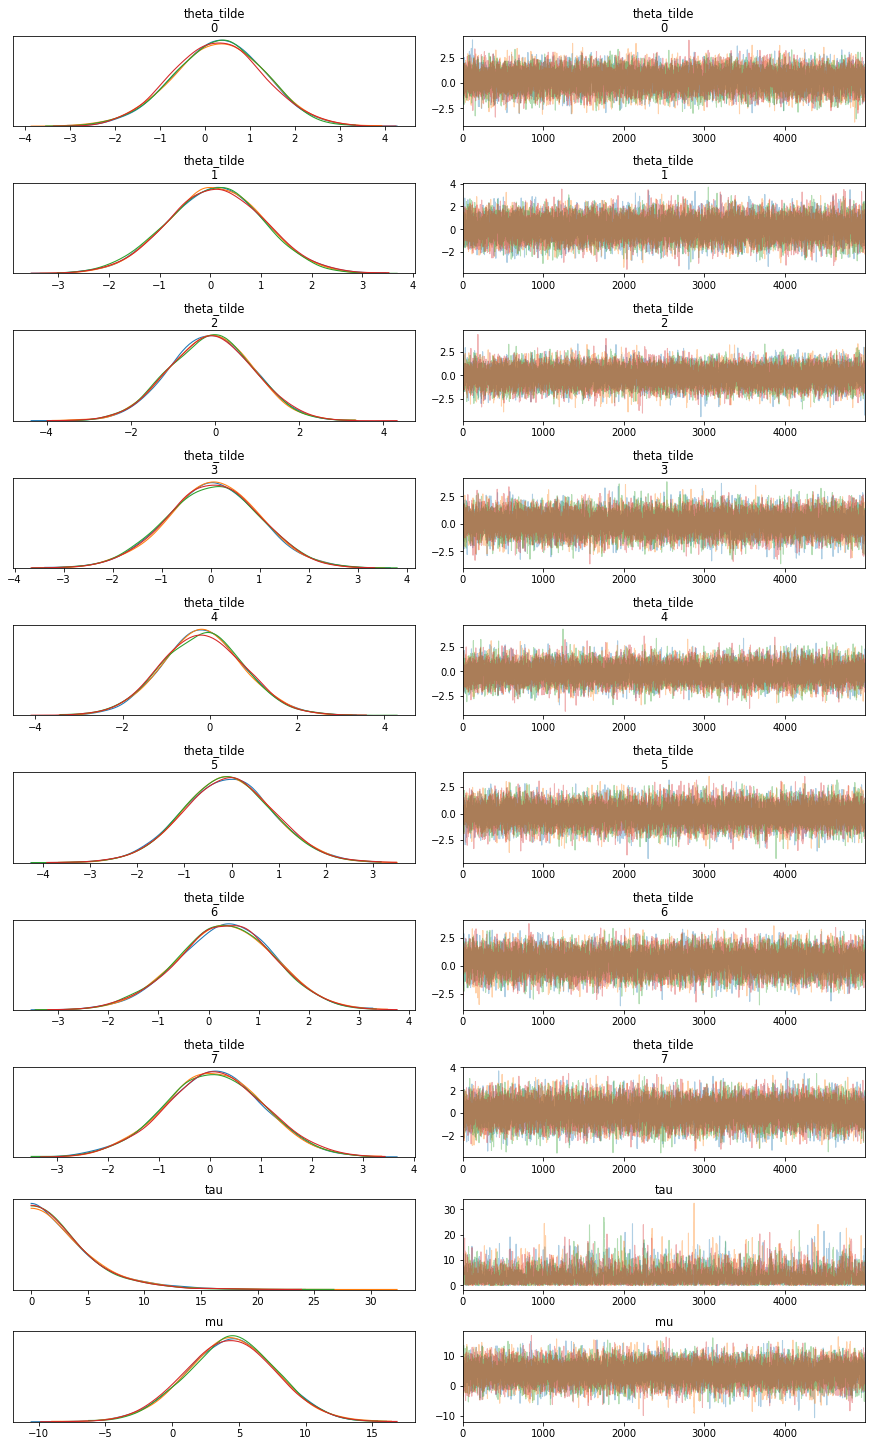

In [11]:
az.plot_trace(idata);

### Display Estimation Summary

In [12]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta_tilde[0],0.313,0.995,-1.515,2.235,0.008,0.006,15763.0,15763.0,15796.0,18473.0,1.0
theta_tilde[1],0.108,0.934,-1.630,1.872,0.007,0.005,19375.0,18443.0,19393.0,19031.0,1.0
theta_tilde[2],-0.095,0.974,-1.902,1.730,0.007,0.005,19755.0,19755.0,19748.0,19292.0,1.0
theta_tilde[3],0.058,0.942,-1.768,1.782,0.007,0.005,19542.0,19130.0,19542.0,19199.0,1.0
theta_tilde[4],-0.159,0.932,-1.903,1.597,0.007,0.005,18596.0,17428.0,18613.0,18591.0,1.0
theta_tilde[5],-0.076,0.952,-1.876,1.709,0.007,0.005,18812.0,18611.0,18805.0,19202.0,1.0
theta_tilde[6],0.350,0.954,-1.430,2.167,0.008,0.005,16129.0,16129.0,16173.0,19623.0,1.0
theta_tilde[7],0.092,0.974,-1.716,1.975,0.007,0.005,19211.0,19211.0,19211.0,19602.0,1.0
tau,3.593,3.198,0.001,9.411,0.049,0.037,4295.0,3800.0,5316.0,5483.0,1.0
mu,4.431,3.326,-1.745,10.760,0.028,0.019,14561.0,14561.0,14678.0,16148.0,1.0
